### Modelling with **emg3d** to design a CSEM survey for monitoring an Aquifer Thermal Energy Storage (ATES) site 

We will use the expected subsurface stratigraphy and related electrical resistivities at the ATES site of TU Delft. 

For more information on the project, have a look at https://www.push-it-thermalstorage.eu/pilots/delft/.

**Adjust the input values to emg3d based on the survey setup you identified as most suitable.**

**Setup 1:** Horizontal bipole source combined with 300 m long horizontal receiver line recording horizontal electric field component.

**Setup 2:** Horizontal bipole source combined with 300 m long vertical receiver line (in borehole) recording vertical electric field component.

**Setup 3:** Vertical bipole source combined with 300 m long vertical receiver line (in borehole) recording vertical electric field component.

**Tasks:** 
- Generate layered background and layered target responses with **empymod**.
- Generate 3D layered and target responses with **emg3d** (optional for different hot plume diameters, max. 160 m). Hot plume is approximated to be cubic.
- Compare layered background and layered target, and 3D layered target responses.
- Look at differences between 3D layered and 3D target responses.


**Questions:**
- Would you change your survey setup based on the 3D simulation results?
- How large must the hot plume be such that you can detect it?

In [1]:
# Uncomment on Google Colab
# %pip install emg3d matplotlib discretize

In [2]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.style.use('bmh')

# Comment this out on Google Colab
%matplotlib widget

## Layered model responses with suitable survey setup
Compute base and target responses with **empymod**.

In [4]:
# You can copy/pased your code snippets for your preferred survey setup from empymod_ATES.ipynb here.

# Source
source = [-200, -210, 0, 0, 0, 0] # x-directed bipole

# Source frequency
frequency_1 = 1

# Receiver offsets
offsets_1 = np.linspace(1, 300, 300)

# receiver-array: x, y, z, azimuth, dip
receivers_1 = [offsets_1, offsets_1*0, 0, 0, 0] # x-directed, Ex response
#receivers_1 = [offsets_1*0, offsets_1*0, offsets_1, 0, 90] # z-directed, Ez response

# Layer boundaries
depth = [0, 45, 80, 120, 185]

# Layer resistivities
resistivities_base = [2e14, 54.7, 38.0, 26.0, 29.5, 16.7] # base
resistivities_target = [2e14, 54.7, 38.0, 26.0, 13.1, 16.7] # target (aquifer +50 °Celsius)

# define the input that stays the same for all models
inp = {
    'src': source,
    'rec': receivers_1,
    'depth': depth,
    'freqtime': frequency_1,
    'srcpts': 5,  # Models the finite-length source as 5 point sources with Gaussian Quadrature
    'htarg': {'pts_per_dec': -1},  # Faster computation
    'verb': 1,
}
resp_E_base = empymod.bipole(res=resistivities_base, **inp)
resp_E_target = empymod.bipole(res=resistivities_target, **inp)

## 3D target response with emg3d

We use a cubic shape for the hot plume.

Maximum diameter with + 50 °C after two years: 160 m.

Create the mesh:

In [14]:
grid = emg3d.construct_mesh(
    center=(0,0,0),   # Center of wanted grid
    frequency=frequency_1,  # Frequency we will use the grid for
    properties=[25, 25, 1e8],         # Reference resistivity
    domain=([-500, 500], [-500, 500], [-185, 0]),   # Domain in which we want precise results
    center_on_edge=True,
    min_width_limits = [20, 20, 5],
)
 
grid  # mesh info
#grid.plot_grid() # plotting the grid

TensorMesh: 737,280 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     96   -101,740.05    101,740.05     20.00 27,291.31    1.37
   y     96   -101,740.05    101,740.05     20.00 27,291.31    1.37
   z     80    -22,376.94    102,185.44      5.00 32,420.86    1.46

Introduce layers, cubic hot plume anomaly and assign resistivities:

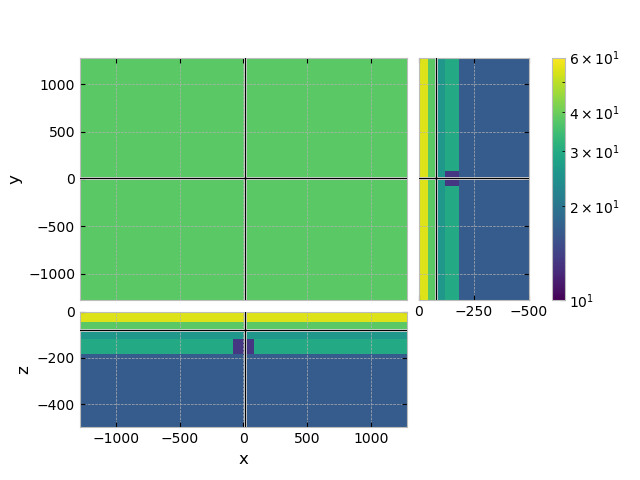

In [15]:
res = np.ones(grid.shape_cells)

# Layered base model:
res[:, :, grid.cell_centers_z > 0] = 2e8 # air resistivity
res[:, :, (grid.cell_centers_z > -45) & (grid.cell_centers_z <= 0)] = 54.7 # first layer depths and resistivity
res[:, :, (grid.cell_centers_z > -80) & (grid.cell_centers_z <= -45)] = 38.0 # second layer depths and resistivity
res[:, :, (grid.cell_centers_z > -120) & (grid.cell_centers_z <= -80)] = 26.0 # third layer depths and resistivity
res[:, :, (grid.cell_centers_z > -185) & (grid.cell_centers_z <= -120)] = 29.5 # reservoir layer depths and resistivity
res[:, :, grid.cell_centers_z <= -185] = 16.7 # resistivity of half space below

# Layered base model
model_base = emg3d.Model(grid, property_x=res, mapping='Resistivity')

# 3D target model
res3 = res
res3 = res3.ravel('F')

# Insert cubic hot plume in reservoir layer with 160 m diameter, centered at zero.
xx = (grid.cell_centers[:, 0] >= -80) & (grid.cell_centers[:, 0] <= 80)
yy = abs(grid.cell_centers[:, 1]) <= 80
zz = (grid.cell_centers[:, 2] > -185) & (grid.cell_centers[:, 2] <= -120)

res3[xx*yy*zz] = 13.3  # Target resistivity

model1 = emg3d.Model(grid, property_x=res3, mapping='Resistivity')

# plot the model with the 3D target
grid.plot_3d_slicer(model1.property_x, pcolor_opts={'norm': LogNorm(vmin=10, vmax=60)},
    zlim = [-500, 0],
    xlim = [-1280, 1280],
    ylim = [-1280, 1280])
plt.gcf().canvas.capture_scroll = True

Generate the source field with a certain frequency:

In [16]:
sfield = emg3d.fields.get_source_field(grid, source=(-200, -210, 0, 0, 0, 0), frequency=frequency_1) # example is x-directed dipole source

Call **emg3d** to solve for the electric field components:

In [17]:
# layered base
efield3D_lay = emg3d.solve(model_base, sfield, verb=2)
# 3D target
efield3D_target = emg3d.solve(model1, sfield, verb=2)

:: emg3d :: 5.7e-07; 4(22); 0:01:06; CONVERGED
:: emg3d :: 6.2e-07; 4(22); 0:01:07; CONVERGED


Specify receiver line and electric field direction you would get the responses for (the same as for base and layered model):

In [18]:
# layered base
resp_E_base_3D = efield3D_lay.get_receiver((offsets_1, offsets_1*0, 0, 0, 0), 'linear')
# 3D target
# WHY DOES Ez in borehole (vertical receiver line) does not give the expected result here?
resp_E_target_3D = efield3D_target.get_receiver((offsets_1, offsets_1*0, 0, 0, 0), 'linear')

Plot your results along the receiver line:

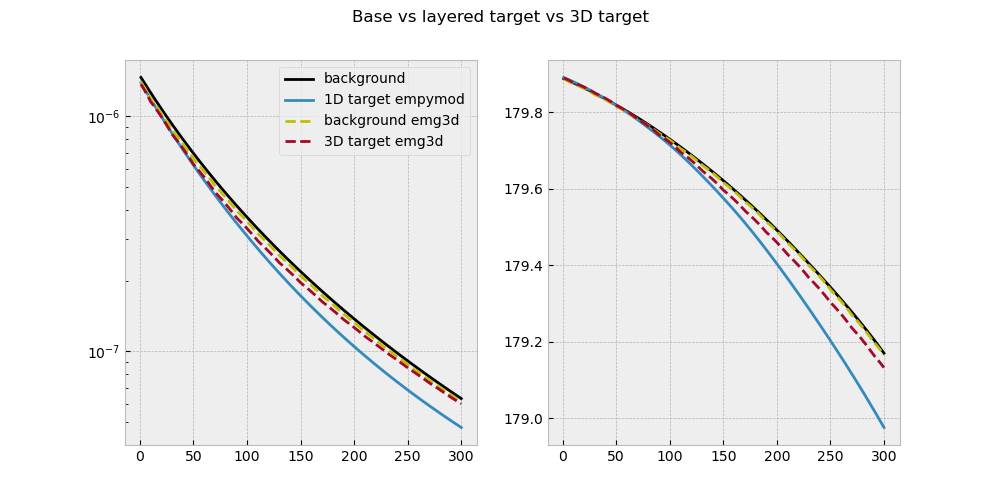

In [19]:
# Plot it
fig3, (ax31, ax32) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

fig3.suptitle("Base vs layered target vs 3D target")

ax31.plot(offsets_1, resp_E_base.amp(), 'k', label='background')
ax31.plot(offsets_1, resp_E_target.amp(), 'C0-', label='1D target empymod')
ax31.plot(offsets_1, resp_E_base_3D.amp()/10, 'y--', label='background emg3d') # scale your emg3d amplitues by the source length
ax31.plot(offsets_1, resp_E_target_3D.amp()/10, 'C1--', label='3D target emg3d') # scale your emg3d amplitues by the source length
ax31.set_yscale('log')
ax31.legend()

ax32.plot(offsets_1, resp_E_base.pha(deg=True), 'k')
ax32.plot(offsets_1, resp_E_target.pha(deg=True), 'C0-')
ax32.plot(offsets_1, resp_E_base_3D.pha(deg=True), 'y--')
ax32.plot(offsets_1, resp_E_target_3D.pha(deg=True), 'C1--')

Plot the **emg3d** response in the entire domain:

In [13]:
grid.plot_3d_slicer(
        efield3D.fx.ravel('F'), view='abs', v_type='Ex',
        pcolor_opts={'norm': LogNorm(vmin=1e-15)},
)
plt.gcf().canvas.capture_scroll = True

NameError: name 'efield3D' is not defined

Plot the **emg3d** response in the inner domain:

In [ ]:
grid.plot_3d_slicer(
        efield3D.fx.ravel('F'), view='abs', v_type='Ex',
        pcolor_opts={'norm': LogNorm(vmin=1e-13, vmax = 1e-4)},
        zlim = [-500, 0],
        xlim = [-1280, 1280],
        ylim = [-1280, 1280]
)   
plt.gcf().canvas.capture_scroll = True

Plot the relative **emg3d** response differences between layered baground and 3D target in the inner domain:

In [ ]:
How to do this?

In [ ]:
emg3d.Report()